In [1]:
!pip install tensorboardX

In [2]:
from time import perf_counter
from datetime import timedelta

import numpy as np
#import cv2
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import tensorboardX
from torch.autograd import grad
from torch.autograd import Variable
import torchvision
import torchvision.transforms as transforms
import shutil
import statistics as st

In [3]:
#from google.colab import drive
#drive.mount('/content/drive')

#!ls 

In [4]:
#cd ~/.local/share/Trash/files/
#mv ~/.local/share/Trash/files/wganGP.ipynb /home/jupyter/

In [5]:
class generator(nn.Module):

    def __init__(self, dim_in, dim=16): # por defecto     dim = 64     ### CONSTRUCTOR DEL GENERADOR
        super(generator,self).__init__()

        #--------------------------------------#
        #--------------------------------------#

        def genblock(dim_in, dim_out, kernel): 
            block = nn.Sequential( nn.ConvTranspose2d(in_channels = dim_in, 
                                                      out_channels = dim_out,
                                                      kernel_size = kernel, # por defecto 5 
                                                      stride=2, 
                                                      padding=2,
                                                      output_padding = 1,
                                                      bias = False),
                                                      nn.BatchNorm2d(dim_out),
                                                      nn.ReLU()
                                                      )
            return block

        def genimg(dim_in, kernel):
            block = nn.Sequential( nn.ConvTranspose2d(in_channels = dim_in, 
                                                      out_channels = 1, # por defecto 3
                                                      kernel_size = kernel, # por defecto 5 
                                                      stride=2, 
                                                      padding=2,
                                                      output_padding = 1,
                                                      ),
                                                      nn.Tanh()
                                                      )
            return block
        


        """
        self.prepare = nn.Sequential(nn.Linear(dim_in, dim*8*4*4, bias=False),
                                     nn.BatchNorm1d(dim*8*4*4),
                                     nn.ReLU())
        
        self.generate = nn.Sequential(genblock(dim*8, dim*4),
                                      genblock(dim*4, dim*2),
                                      genblock(dim*2, dim),

                                      genimg(dim))
        """

        #--------------------------------------#

        self.prepare = nn.Sequential(nn.Linear(100, 1024, bias=False),
                                     nn.BatchNorm1d(1024),
                                     nn.ReLU())
        
        self.generate = nn.Sequential(genblock(64, 32, 1),
                                      genblock(32, 16,  1),
                                      genblock(16, 8,  2),

                                      genimg(8,        3))
        

        #--------------------------------------#
        #--------------------------------------#

    def forward(self, x):

        #print("!!!------------------------esto es forward generador---")
        #print(x.size())
        #print()
        
        x = self.prepare(x)
        x = x.view(x.size(0), -1,4,4)
        x = self.generate(x)

        #print("!!!------------------------esto es final forward generador---")

        return x





class critic(nn.Module):
    def __init__(self, dim_in, dim=8): # por defecto     dim = 64        ### CONSTRUCTOR DEL DISCRIMINADOR
        super(critic, self).__init__()
        
        def critic_block(dim_in , dim_out, kernel):
            block = nn.Sequential(nn.Conv2d(in_channels = dim_in, 
                                            out_channels = dim_out,
                                            kernel_size = kernel, # por defecto 5 
                                            stride=2, 
                                            padding=2),
                                            nn.InstanceNorm2d(dim_out, affine= True),
                                            nn.LeakyReLU(0.2))
            return block

        #--------------------------------------#
        #--------------------------------------#

        self.analyze = nn.Sequential(nn.Conv2d(in_channels = dim_in, 
                                               out_channels = dim, 
                                               kernel_size = 1, # por defecto 5  
                                               stride=2, 
                                               padding=2),
                                      
                                     nn.LeakyReLU(0.2),

                                     critic_block(dim,dim*2, 2),
                                     critic_block(dim*2,dim*4, 2),
                                     critic_block(dim*4, dim*8, 2),
                                     
                                     nn.Conv2d(in_channels=dim*8, 
                                               out_channels=1,
                                               kernel_size=2)) # por defecto    kernel_size = 4

        #--------------------------------------#
        #--------------------------------------#    
    
    def forward(self,x):
        x = self.analyze(x)
        x = x.view(-1)

        return x

In [6]:
def gradient_penalty(x,y,f):
    shape =[x.size(0)] + [1] * (x.dim() -1)
    #print("---------gradient penalty--------")
    #print(shape)
    #print()

    alpha = torch.rand(shape)
    z = x+ alpha *(y-x)
    z = Variable(z,requires_grad=True)
    z=z
    o=f(z)
    g = grad(o,z, grad_outputs=torch.ones(o.size()), create_graph=True)[0].view(z.size(0), -1)
    gp = ((g.norm(p=2,dim=1))**2).mean()
    return gp

In [7]:

def save_checkpoint(state, save_path, is_best=False, max_keep=None):
    # save checkpoint
    torch.save(state, save_path)

    # deal with max_keep
    save_dir = os.path.dirname(save_path)
    list_path = os.path.join(save_dir, 'latest_checkpoint')

    save_path = os.path.basename(save_path)
    if os.path.exists(list_path):
        with open(list_path) as f:
            ckpt_list = f.readlines()
            ckpt_list = [save_path + '\n'] + ckpt_list
    else:
        ckpt_list = [save_path + '\n']

    if max_keep is not None:
        for ckpt in ckpt_list[max_keep:]:
            ckpt = os.path.join(save_dir, ckpt[:-1])
            if os.path.exists(ckpt):
                os.remove(ckpt)
        ckpt_list[max_keep:] = []

    with open(list_path, 'w') as f:
        f.writelines(ckpt_list)

    # copy best
    if is_best:
        shutil.copyfile(save_path, os.path.join(save_dir, 'best_model.ckpt'))


In [8]:
def load_checkpoint(ckpt_dir_or_file, map_location=None, load_best=False):
    if os.path.isdir(ckpt_dir_or_file):
        if load_best:
            ckpt_path = os.path.join(ckpt_dir_or_file, 'best_model.ckpt')
        else:
            with open(os.path.join(ckpt_dir_or_file, 'latest_checkpoint')) as f:
                ckpt_path = os.path.join(ckpt_dir_or_file, f.readline()[:-1])
    else:
        ckpt_path = ckpt_dir_or_file
    ckpt = torch.load(ckpt_path, map_location=map_location)
    print(' [*] Loading checkpoint from %s succeed!' % ckpt_path)
    return ckpt


In [9]:
epochs = 500
batch_size = 16
n_critic=5
lr=0.0002
z_dim = 100

transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])]) #normaliza el dataset de imagenes en valores entre [-1,1]

data = torchvision.datasets.ImageFolder("/home/jupyter/imagenes_entrenamiento_generador", transform = transform) # carpeta con imagenes dataset de entrenamiento



dataloader = torch.utils.data.DataLoader(data,
                                         batch_size=batch_size, # numero de imagenes convertidas en tensores se cogen del dataset
                                         shuffle=True) 
C = critic(1,8) # 3 por defecto
G = generator(z_dim)

#G = generator(z_dim,30)

#C = C.cuda()
#G = G.cuda()

print("Generator : ")
print(G)
print()
print()
print("Critic")
print(C)
print()


start_epoch=0

G_opt = torch.optim.Adam(G.parameters(), lr=lr, betas=(0.5,0.999))
C_opt = torch.optim.Adam(C.parameters(), lr=lr, betas=(0.5,0.999))

Generator : 
generator(
  (prepare): Sequential(
    (0): Linear(in_features=100, out_features=1024, bias=False)
    (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (generate): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(64, 32, kernel_size=(1, 1), stride=(2, 2), padding=(2, 2), output_padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): Sequential(
      (0): ConvTranspose2d(32, 16, kernel_size=(1, 1), stride=(2, 2), padding=(2, 2), output_padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (2): Sequential(
      (0): ConvTranspose2d(16, 8, kernel_size=(2, 2), stride=(2, 2), padding=(2, 2), output_padding=(1, 1), bias=False)
      (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     

In [10]:
checkpoint = "/home/jupyter/checkpoint"
save_dir = '/home/jupyter/imagenes_epoch' # carpeta para guardar la imagenes que va sacando en los epoch

if not isinstance(checkpoint, (list, tuple)):
    paths = [checkpoint]
    for path in paths:
        if not os.path.isdir(path):
            os.makedirs(path)
if not isinstance(save_dir, (list, tuple)):
    paths = [save_dir]
    for path in paths:
        if not os.path.isdir(path):
            os.makedirs(path)
try:
    ckpt = load_checkpoint(checkpoint)
    start_epoch = ckpt['epoch']
    C.load_state_dict(ckpt['D'])
    G.load_state_dict(ckpt['G'])
    C_opt.load_state_dict(ckpt['d_optimizer'])
    G_opt.load_state_dict(ckpt['g_optimizer'])
    
except:
    print(' [*] No checkpoint!')
    start_epoch = 0



 [*] No checkpoint!


In [ ]:
#G_loss_cargado = np.load("/home/jupyter/arrays_loss/G_loss.npy")

In [ ]:
#G_loss = G_loss_cargado.tolist()

In [ ]:
#C_loss_cargado = np.load("/home/jupyter/arrays_loss/D_loss.npy")

In [ ]:
#C_loss = C_loss_cargado.tolist()

In [ ]:
len(G_loss)

In [ ]:
len(C_loss)

In [11]:
start_time=perf_counter() # empieza tiempo


C_loss= []
G_loss=[]


#writer = tensorboardX.SummaryWriter('/home/jupyter/summary')

z_sample = Variable(torch.randn(1, z_dim))

for epoch in range(start_epoch, epochs):

    #print("$$$$$$ -------------------------------------------------------------------------- $$$$$$")
    #print("$$$$$$ -------------------------- esto es epoch numero -------------------------- $$$$$$")
    #print("$$$$$$ -------------------------------------------------------------------------- $$$$$$")
    #print(epoch)
    #print()
    
    G.train()

    for i, (images, _) in enumerate(dataloader):    # enumerate(dataloader) asigna al primer batch_size el numero 0, al segundo batch_size el numero 1 ...
                                                    # coger [batch_size] imagenes del dataset de entrenamiento

        #print("---esto es i---")
        #print(i)
        #print()
        
        #print("---esto es images---")
        #print(images.size()) # son tantas imagenes 8x8 como [batch_size]
        #print()   
            
        step = epoch * len(dataloader) + i + 1
        
        #print("---esto es longitud dataloader---")
        #print(len(dataloader))
        #print()
        
        #print("######## ------------------ esto es step numero ----------------- ########")
        #print(step)
        #print()

        images = Variable(images)
        batch = images.size(0)  # batch = batch_size
        images = images
        z = Variable(torch.randn(batch, z_dim)) # vector de ruido se crean [batch_size] filas y [z_dim] columnas
        z = z
        
        #print("---esto es batch---")
        #print(batch)
        #print()

        #print("---esto es images---")
        #print(images.size())
        #print()

        
        #print("---esto es z---")
        #print(z.size())
        #print()

        generated = G(z)

        #print("---esto es generated---")
        #print(generated.size())
        #print()


        real_criticized = C(images) #al pasar por el discrimnador se genera un vector de ( [batch_size] · 9 ) valores
        fake_criticized = C(generated)

        #print("---esto es real.criticized---")
        #print(real_criticized.size())
        #print()

        #print("---esto es fake.criticized---")
        #print(fake_criticized.size())
        #print()
        
        em_distance = real_criticized.mean() - fake_criticized.mean() # EARTH MOVERS DISTANCE O WASSERTEIN

        #print("---esto es em_distance---")
        #print(em_distance)
        #print()

        #print("---esto es images.data---")
        #print(images.data.size())
        #print()

        #print("---esto es generated.data---")
        #print(generated.data.size())
        #print()

        grad_penalty = gradient_penalty(images.data, generated.data, C)
        
        CriticLoss = -em_distance + grad_penalty*10

        C_loss.append(CriticLoss.item()) ##############################################################
        C.zero_grad()
        CriticLoss.backward()
        C_opt.step()
      

        # writer.add_scalar('C/em_dist', em_distance.data.cpu().numpy(), global_step = step)
        # writer.add_scalar('C/gp', grad_penalty.data.cpu().numpy(), global_step = step)
        # writer.add_scalar('C/c_loss', CriticLoss.data.cpu().numpy(), global_step = step)


        if step % n_critic == 0:
            z = Variable(torch.randn(batch, z_dim)) # [batch] filas y [z_dim] columnas
            z = z
            generated = G(z)
            fake_criticized = C(generated)
            GenLoss = -fake_criticized.mean()
            G_loss.append(GenLoss.item())   ##############################################################
            C.zero_grad() # poner los gradientes a cero
            G.zero_grad() # poner los gradientes a cero
            GenLoss.backward()
            G_opt.step()

            #print("[[---GENERADOR---]]")
            #print()


        # writer.add_scalars('G', {"g_loss":GenLoss.data.cpu().numpy()},
        #                            global_step = step)

            print("Epoch {}/{} : {}/{}".format(epoch+1,epochs, i+1, len(dataloader)), end='\r')

    #print("Epoch {}/{} : Critic Loss = {}, Gen Loss = {}".format(epoch+1, epochs, st.mean(C_loss), st.mean(G_loss)))

    print()
    #print("Epoch {}/{}".format(epoch+1, epochs))
    #print()
    
    G.eval()
    #fake_gen_images = (G(z_sample).data +1)/2.0
    fake_gen_images = G(z_sample)

    torchvision.utils.save_image(fake_gen_images, save_dir+'/Epoch '+str(epoch+1)+".png",nrow=1) # guardar imagen del epoch ######################################################## n_rows

    x=torchvision.utils.make_grid(fake_gen_images, nrow=4) # guardar imagen del epoch




    end_time=perf_counter() # acaba tiempo

    duration = timedelta( seconds=end_time-start_time )
 
    print("--------------# acabado en:", duration, " #-----------------") #Output program running time
    print()
    print()    


    np.save("/home/jupyter/arrays_loss/G_loss.npy", G_loss)
    np.save("/home/jupyter/arrays_loss/D_loss.npy", C_loss)
    

    save_checkpoint({'epoch': epoch + 1,
                           'D': C.state_dict(),
                           'G': G.state_dict(),
                           'd_optimizer': C_opt.state_dict(),
                           'g_optimizer': G_opt.state_dict()},
                           '%s/Epoch_(%d).ckpt' % (checkpoint, epoch + 1), # guardar el checkpoint
                            max_keep=500)

Epoch 1/500 : 2780/2783
--------------# acabado en: 0:02:15.769815  #-----------------


Epoch 2/500 : 2782/2783
--------------# acabado en: 0:04:30.767725  #-----------------


Epoch 3/500 : 2779/2783
--------------# acabado en: 0:06:43.838923  #-----------------


Epoch 4/500 : 2781/2783
--------------# acabado en: 0:08:55.252917  #-----------------


Epoch 5/500 : 2783/2783
--------------# acabado en: 0:11:06.698859  #-----------------


Epoch 6/500 : 2780/2783
--------------# acabado en: 0:13:17.883078  #-----------------


Epoch 7/500 : 2782/2783
--------------# acabado en: 0:15:29.510528  #-----------------


Epoch 8/500 : 2779/2783
--------------# acabado en: 0:17:40.552052  #-----------------


Epoch 9/500 : 2781/2783
--------------# acabado en: 0:19:51.838518  #-----------------


Epoch 10/500 : 2783/2783
--------------# acabado en: 0:22:03.061017  #-----------------


Epoch 11/500 : 2780/2783
--------------# acabado en: 0:24:14.462579  #-----------------


Epoch 12/500 : 2782

In [ ]:
"""
batch_size = 8 -> len(dataloader) = 5566  --- 125 pasos/epoch
batch_size = 16 -> len(dataloader) = 2782 --- 63 pasos/epoch
batch_size = 32 -> len(dataloader) = 1391 --- 32 pasos/epoch
batch_size = 64 -> len(dataloader) = 696  --- 16 pasos/epoch
batch_size = 128 -> len(dataloader) = 348 --- 8 pasos/epoch
batch_size = 256 -> len(dataloader) = 174 --- 4 pasos/epoch
batch_size = 512 -> len(dataloader) = 87  --- 2 pasos/epoch
"""

# **GRAFICAS**

In [ ]:
len(C_loss)

In [ ]:
#C_loss

In [ ]:
len(G_loss)

In [ ]:
#G_loss

In [12]:
pasos1 =  len(C_loss) // epochs 

print(pasos1)

C_loss_prueba = C_loss[0:len(C_loss):pasos1]

print(len(C_loss_prueba))

array = range(len(C_loss_prueba))

2783
500


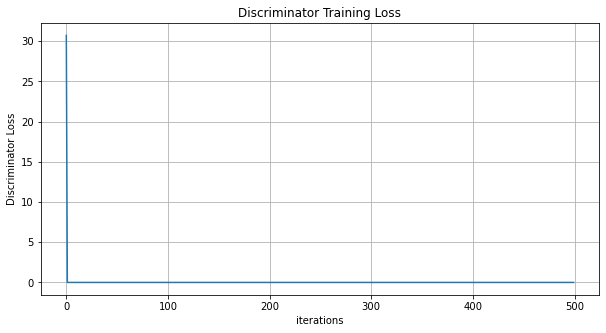

In [13]:
plt.figure(figsize=(10,5))
plt.title("Discriminator Training Loss")
plt.plot(array,C_loss_prueba,label="val")
plt.xlabel("iterations")
plt.ylabel("Discriminator Loss")
plt.grid()
plt.savefig("/home/jupyter/graficas_entrenamiento_generador/d_loss")
plt.show()

In [14]:
pasos2 = len(G_loss) // epochs

print(pasos2)

#G_loss_prueba = G_loss[0:len(G_loss):pasos2]

G_loss_prueba = G_loss[0:500]

print(len(G_loss_prueba))

array = range(len(G_loss_prueba))

556
500


In [15]:
#import itertools
#G_loss = list(itertools.chain.from_iterable(itertools.repeat(x, 2) for x in G_loss))
#G_loss_prueba = G_loss[0:500]

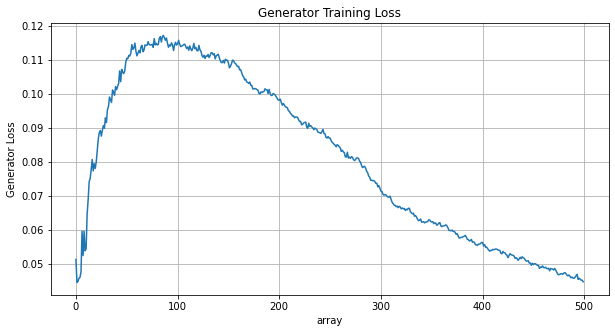

In [16]:
plt.figure(figsize=(10,5))
plt.title("Generator Training Loss")
plt.plot(array,G_loss_prueba,label="train")
#plt.xlabel("iterations")
plt.xlabel("array")
plt.ylabel("Generator Loss")
plt.grid()
plt.savefig("/home/jupyter/graficas_entrenamiento_generador/g_loss")
plt.show()

In [ ]:
!ls

In [ ]:
!tar chvfz archivos_generador.tar.gz "/home/jupyter/imagenes_entrenamiento_clasificador/test/ataques_generados"

In [ ]:
!tar chvfz archivos_generador.tar.gz "/home/jupyter/imagenes_epoch" "/home/jupyter/graficas_entrenamiento_generador" "/home/jupyter/imagenes_entrenamiento_clasificador/test/ataques_generados"

In [ ]:
!tar chvfz imagenes_epoch.tar.gz "/home/jupyter/imagenes_epoch"

In [17]:
!tar chvfz checkpoint.tar.gz "/home/jupyter/checkpoint"

tar: Removing leading `/' from member names
/home/jupyter/checkpoint/
/home/jupyter/checkpoint/Epoch_(275).ckpt
tar: Removing leading `/' from hard link targets
/home/jupyter/checkpoint/Epoch_(149).ckpt
/home/jupyter/checkpoint/Epoch_(484).ckpt
/home/jupyter/checkpoint/Epoch_(380).ckpt
/home/jupyter/checkpoint/Epoch_(241).ckpt
/home/jupyter/checkpoint/Epoch_(292).ckpt
/home/jupyter/checkpoint/Epoch_(280).ckpt
/home/jupyter/checkpoint/Epoch_(200).ckpt
/home/jupyter/checkpoint/Epoch_(392).ckpt
/home/jupyter/checkpoint/Epoch_(305).ckpt
/home/jupyter/checkpoint/Epoch_(321).ckpt
/home/jupyter/checkpoint/Epoch_(402).ckpt
/home/jupyter/checkpoint/Epoch_(357).ckpt
/home/jupyter/checkpoint/Epoch_(331).ckpt
/home/jupyter/checkpoint/Epoch_(24).ckpt
/home/jupyter/checkpoint/Epoch_(214).ckpt
/home/jupyter/checkpoint/Epoch_(187).ckpt
/home/jupyter/checkpoint/Epoch_(170).ckpt
/home/jupyter/checkpoint/Epoch_(406).ckpt
/home/jupyter/checkpoint/Epoch_(165).ckpt
/home/jupyter/checkpoint/Epoch_(207).ckpt
